In [1]:
from tensorflow.keras.utils import image_dataset_from_directory

images = image_dataset_from_directory("/kaggle/input/stanford-dogs-dataset-traintest/cropped/cropped/train", 
                                      seed=1234, subset="both", validation_split=0.2, batch_size=32, 
                                      labels="inferred", label_mode = "categorical")
images[0]

2024-02-06 11:11:43.038786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 11:11:43.038899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 11:11:43.258628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 12000 files belonging to 120 classes.
Using 9600 files for training.
Using 2400 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():

    model = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

    return model

def set_nontrainable_layers(model):

    model.trainable = False

    return model

model = load_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [3]:
from tensorflow.keras import layers, models
import tensorflow as tf

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(120, activation='softmax')
    model = tf.keras.Sequential([
      model,
      flattening_layer,
      dense_layer,
      prediction_layer
    ])

    return model

In [4]:
from tensorflow.keras import optimizers

def build_model():
    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)
    model = add_last_layers(base_model)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])
    return model

In [5]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

images_preprocessed = images[0].map(
  lambda x, y: (preprocess_input(x), y))
images_val_prepocessed = images[1].map(
  lambda x, y: (preprocess_input(x), y))

model = build_model()
model.summary()
es = EarlyStopping(patience=3)
history = model.fit(images_preprocessed,
          epochs=100,
          batch_size=32,
          callbacks=es,
          validation_data=images_val_preprocessed,
          verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 500)               16384500  
                                                                 
 dense_1 (Dense)             (None, 120)               60120     
                                                                 
Total params: 31159308 (118.86 MB)
Trainable params: 16444620 (62.73 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/100


I0000 00:00:1707217934.671841     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 72s 197ms/step - loss: 6.2604 - accuracy: 0.1120 - val_loss: 3.7971 - val_accuracy: 0.1950
Epoch 2/100
300/300 [==============================] - 64s 213ms/step - loss: 1.7720 - accuracy: 0.5498 - val_loss: 3.1341 - val_accuracy: 0.3579
Epoch 3/100
300/300 [==============================] - 64s 211ms/step - loss: 0.3929 - accuracy: 0.8878 - val_loss: 3.1057 - val_accuracy: 0.4108
Epoch 4/100
300/300 [==============================] - 64s 212ms/step - loss: 0.0886 - accuracy: 0.9782 - val_loss: 3.1483 - val_accuracy: 0.4421
Epoch 5/100
300/300 [==============================] - 65s 214ms/step - loss: 0.0410 - accuracy: 0.9939 - val_loss: 3.2470 - val_accuracy: 0.4454
Epoch 6/100
300/300 [==============================] - 64s 213ms/step - loss: 0.0428 - accuracy: 0.9928 - val_loss: 3.3234 - val_accuracy: 0.4617


In [6]:
test_images = image_dataset_from_directory("/kaggle/input/stanford-dogs-dataset-traintest/cropped/cropped/test", 
                                      seed=1234, batch_size=32, 
                                      labels="inferred", label_mode = "categorical")
results = model.evaluate(test_images)

Found 12000 files belonging to 120 classes.
375/375 [==============================] - 63s 167ms/step - loss: 4.5205 - accuracy: 0.3626


[4.520523548126221, 0.36258333921432495]

# Why not iterate over different base models to check which one is the best?

In [ ]:
import tensorflow.keras.applications as pmodels
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

def test_base_models():
    images = image_dataset_from_directory("/kaggle/input/stanford-dogs-dataset-traintest/cropped/cropped/train", 
                                      seed=1234, subset="both", validation_split=0.2, batch_size=32, 
                                      labels="inferred", label_mode = "categorical")
    test_images = image_dataset_from_directory("/kaggle/input/stanford-dogs-dataset-traintest/cropped/cropped/test", 
                                      seed=1234, batch_size=32, 
                                      labels="inferred", label_mode = "categorical")
    base_models = [pmodels.vgg16.VGG16, pmodels.efficientnet_v2.EfficientNetV2L, pmodels.inception_v3.InceptionV3, pmodels.xception.Xception, pmodels.MobileNetV3Large]
    preprocess_func = [pmodels.vgg16.preprocess_input, do_nothing, pmodels.inception_v3.preprocess_input, pmodels.xception.preprocess_input, do_nothing]
    histories = []
    scores = []
    models = []
    for index, base_model in enumerate(base_models):
        model = build_model(base_model)
        images_train = images[0].map(lambda x, y: (preprocess_func[index](x), y))
        images_val = images[1].map(lambda x, y: (preprocess_func[index](x), y))
        images_test = test_images.map(lambda x, y: (preprocess_func[index](x), y))
        history = train_model(model, images_train, images_val)
        score = evaluate_model(model, images_test)
        histories.append(history)
        scores.append(score)
        models.append(model)
    return histories, scores, models, base_models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(120, activation='softmax')
    model = models.Sequential([
      model,
      flattening_layer,
      dense_layer,
      prediction_layer
    ])

    return model

def build_model(base_model):
    model = load_model(base_model)
    model = set_nontrainable_layers(model)
    model = add_last_layers(model)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
    return model

def load_model(base_model):
    model = base_model(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    return model

def set_nontrainable_layers(model):
    model.trainable = False
    return model

def train_model(model, images_train, images_val):
    model.summary()
    es = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
    history = model.fit(images_train,
              epochs=100,
              batch_size=32,
              callbacks=es,
              validation_data=images_val,
              verbose=1)
    return history

def evaluate_model(model, images_test):
    return model.evaluate(images_test)

def do_nothing(object):
    return object

histories, scores, models, base_models = test_base_models()

2024-02-06 14:12:30.939147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 14:12:30.939232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 14:12:31.113606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 12000 files belonging to 120 classes.
Using 9600 files for training.
Using 2400 files for validation.
Found 8580 files belonging to 120 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 500)               16384500  
                                                                 
 dense_1 (Dense)             (None, 120)               60120     
                                                                 
Total params: 31159308 (118.86 MB)
Trainable params: 16444620 (62.73 MB)
Non-trainable params: 14714688 

I0000 00:00:1707228782.952217      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 71s 194ms/step - loss: 6.3200 - accuracy: 0.1098 - val_loss: 3.7203 - val_accuracy: 0.2033
Epoch 2/100
300/300 [==============================] - 64s 211ms/step - loss: 1.7452 - accuracy: 0.5562 - val_loss: 3.2862 - val_accuracy: 0.3296
Epoch 3/100
300/300 [==============================] - 63s 210ms/step - loss: 0.4148 - accuracy: 0.8838 - val_loss: 3.2572 - val_accuracy: 0.3958
Epoch 4/100
300/300 [==============================] - 64s 212ms/step - loss: 0.1054 - accuracy: 0.9766 - val_loss: 3.2691 - val_accuracy: 0.4267
Epoch 5/100
300/300 [==============================] - 64s 211ms/step - loss: 0.0575 - accuracy: 0.9910 - val_loss: 3.3641 - val_accuracy: 0.4529
Epoch 6/100
300/300 [==============================] - 64s 211ms/step - loss: 0.0525 - accuracy: 0.9911 - val_loss: 3.4077 - val_accuracy: 0.4442
Epoch 7/100
300/300 [==============================] - 64s 212ms/step - loss: 0.0334 - accuracy: 0.9969 - val_loss: 3.3992 - val_accurac

2024-02-06 14:24:00.707732: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 228s 656ms/step - loss: 0.9261 - accuracy: 0.8021 - val_loss: 0.4908 - val_accuracy: 0.8879
Epoch 2/100
300/300 [==============================] - 186s 620ms/step - loss: 0.2822 - accuracy: 0.9277 - val_loss: 0.4540 - val_accuracy: 0.9025
Epoch 3/100
291/300 [============================>.] - ETA: 4s - loss: 0.1859 - accuracy: 0.9460

<BarContainer object of 4 artists>

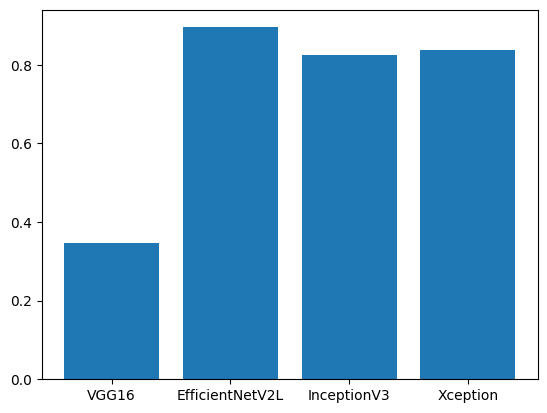

In [24]:
import matplotlib.pyplot as plt

accuracies = [i[1] for i in scores]
model_names = [i.__name__ for i in base_models]
plt.bar(model_names, height=accuracies)